In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('nyc_pluto_20v5_csv/pluto.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

/Users/shweta/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (19,20,22,24,64) have mixed types.Specify dtype option on import or set low_memory=False.



I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '45590bd6-8131-4b02-bd85-bc5628c9b58f',
 …

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [5]:
# Start your answer here, inserting more cells as you go along

# Lets see the data first
ny.head()

borough  block  lot     cd  ct2010  cb2010  schooldist  council  zipcode  \
17       BK   8366  222  318.0  696.02  2002.0        22.0     46.0  11234.0   
58       BK   2571   28  301.0  561.00  1005.0        14.0     33.0  11222.0   
79       BK   3197    8  304.0  429.00  1002.0        32.0     34.0  11237.0   
110      QN     52    7  402.0    7.00  1000.0        30.0     26.0  11101.0   
126      BK   6714   55  314.0  534.00  3000.0        21.0     44.0  11230.0   

    firecomp  ...        appbbl     appdate  plutomapid  firm07_flag  \
17      E323  ...  3.083660e+09  04/26/2019           1          NaN   
58      L106  ...  3.025710e+09  05/09/2019           1          NaN   
79      E218  ...           NaN         NaN           1          NaN   
110     L115  ...           NaN         NaN           1          NaN   
126     L156  ...           NaN         NaN           1          NaN   

     pfirm15_flag version dcpedited   latitude  longitude notes  
17            NaN    20v5       NaN  40.621954 -73.912938   NaN  
58            NaN    20v5       NaN  40.727214 -73.957625   NaN  
79            NaN    20v5       NaN  40.701450 -73.926539   NaN  
110           NaN    20v5       NaN  40.747702 -73.948207   NaN  
126           NaN    20v5       NaN  40.622939 -73.963523   NaN  

[5 rows x 90 columns]

In [6]:
# Columns in the data
ny.columns

Index(['borough', 'block', 'lot', 'cd', 'ct2010', 'cb2010', 'schooldist',
       'council', 'zipcode', 'firecomp', 'policeprct', 'healthcenterdistrict',
       'healtharea', 'sanitboro', 'sanitdistrict', 'sanitsub', 'address',
       'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1',
       'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone',
       'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername',
       'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource',
       'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront',
       'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode',
       'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot',
       'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark',
       'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl',
       'condono', 'tract2010', 'xcoo

In [7]:
# All columns info
ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811022 entries, 17 to 858188
Data columns (total 90 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   borough               811022 non-null  object 
 1   block                 811022 non-null  int64  
 2   lot                   811022 non-null  int64  
 3   cd                    810931 non-null  float64
 4   ct2010                810931 non-null  float64
 5   cb2010                810931 non-null  float64
 6   schooldist            810888 non-null  float64
 7   council               810931 non-null  float64
 8   zipcode               810879 non-null  float64
 9   firecomp              810885 non-null  object 
 10  policeprct            810888 non-null  float64
 11  healthcenterdistrict  810888 non-null  float64
 12  healtharea            810888 non-null  float64
 13  sanitboro             810871 non-null  float64
 14  sanitdistrict         810871 non-null  float64
 15 

In [8]:
# Describe column 'numfloors'
ny['numfloors'].describe()

count    811022.000000
mean          2.455264
std           1.951258
min           0.100000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: numfloors, dtype: float64

In [9]:
# Describe column 'yearbuilt'
ny['yearbuilt'].describe()

count    811022.000000
mean       1941.020131
std          30.449512
min        1851.000000
25%        1920.000000
50%        1931.000000
75%        1960.000000
max        2019.000000
Name: yearbuilt, dtype: float64

In [10]:
#DataFrame for stats on number of floors for each year 
ny_subset = ny[['yearbuilt','numfloors']]
stats_year_numfloor = ny_subset['numfloors'].groupby(ny_subset['yearbuilt']).describe()
stats_year_numfloor.head()

count      mean       std  min  25%  50%  75%   max
yearbuilt                                                     
1851.0      89.0  3.561798  0.979391  2.0  3.0  3.0  4.0   7.0
1852.0     209.0  3.452153  0.789113  1.0  3.0  3.0  4.0   6.0
1853.0     246.0  3.345528  0.909149  2.0  3.0  3.0  4.0  11.0
1854.0     239.0  3.678870  0.943890  1.0  3.0  3.0  4.0   7.0
1855.0     268.0  3.453358  0.751196  2.0  3.0  3.0  4.0   6.0

In [11]:
#DataFrame for stats on number of floors for each year 
stats_year_numfloor.tail()

count      mean       std  min  25%  50%    75%   max
yearbuilt                                                        
2015.0     1706.0  4.962175  8.204611  1.0  2.0  3.0  4.000  88.0
2016.0     1659.0  4.190416  5.216245  1.0  2.0  3.0  4.000  71.0
2017.0     1797.0  4.244736  5.288578  0.8  2.0  3.0  4.000  64.0
2018.0     1589.0  4.364770  5.467218  1.0  2.0  3.0  4.000  67.0
2019.0     1555.0  4.450244  5.546736  0.1  2.0  3.0  4.315  66.0

### Above statistics show mean, median and max number of floors per year. 

In [12]:

print('Min of minimum number of floors across all years: ' + str(stats_year_numfloor['min'].min()))
print('Max of minimum number of floors across all years: ' + str(stats_year_numfloor['min'].max()))
print('Min of median number of floors across all years: ' + str(stats_year_numfloor['50%'].min()))
print('Max of median number of floors across all years: ' + str(stats_year_numfloor['50%'].max()))
print('Min of maximum number of floors across all years: ' + str(stats_year_numfloor['max'].min()))
print('Max of maximum number of floors across all years: ' + str(stats_year_numfloor['max'].max()))

Min of minimum number of floors across all years: 0.1
Max of minimum number of floors across all years: 2.0
Min of median number of floors across all years: 2.0
Max of median number of floors across all years: 5.0
Min of maximum number of floors across all years: 5.0
Max of maximum number of floors across all years: 104.0


In [13]:
# create a copy of ny data for columns needed
ny_subset = ny[['yearbuilt', 'numfloors', 'bbl']].copy()

# floors starting with 1,11,21,31 .... 101
floors = ((np.ceil(ny_subset['numfloors']) - 1) // 10 * 10 + 1).astype(int) 

# initialize the bin range 
ny_subset['bin_range'] = ['{0:03d} - {1:03d} Floors'.format(x, x+9) for x in floors]

# group by numfloors
ny_subset_bin = ny_subset.groupby(['yearbuilt', 'bin_range', 'numfloors'])

# ny_subset_bin
ny_subset_bin.head()

yearbuilt  numfloors           bbl         bin_range
17         2019.0       2.00  3.083660e+09  001 - 010 Floors
58         2018.0       3.00  3.025710e+09  001 - 010 Floors
79         1931.0       3.00  3.031970e+09  001 - 010 Floors
110        1958.0       5.00  4.000520e+09  001 - 010 Floors
126        1931.0       2.00  3.067140e+09  001 - 010 Floors
...           ...        ...           ...               ...
856744     1890.0      13.00  1.002128e+09  011 - 020 Floors
856934     1946.0       0.21  3.020880e+09  001 - 010 Floors
857775     1898.0       1.00  3.070370e+09  001 - 010 Floors
857853     1900.0       5.50  1.001410e+09  001 - 010 Floors
858057     1986.0      27.00  1.008508e+09  021 - 030 Floors

[14104 rows x 4 columns]

In [14]:
#dataframe for number of floors
ny_floors_ct = pd.DataFrame()
#create new column
ny_floors_ct['count'] = ny_subset_bin['numfloors'].count()
# check it out
ny_floors_ct.head(20)

count
yearbuilt bin_range        numfloors       
1851.0    001 - 010 Floors 2.00           5
                           2.50           2
                           3.00          43
                           3.50           4
                           4.00          21
                           5.00          11
                           6.00           1
                           7.00           2
1852.0    001 - 010 Floors 1.00           1
                           2.00           8
                           2.50           1
                           3.00         117
                           3.50           2
                           4.00          59
                           4.50           2
                           5.00          15
                           6.00           4
1853.0    001 - 010 Floors 2.00          14
                           2.50           9
                           2.75           2

In [15]:
# pivot final data frame
ny_finalsub = ny_floors_ct.groupby(['yearbuilt','bin_range']).sum()['count'].unstack(level=-1, fill_value=0)

# checkout the data
ny_finalsub.head(10)

bin_range  001 - 010 Floors  011 - 020 Floors  021 - 030 Floors  \
yearbuilt                                                         
1851.0                   89                 0                 0   
1852.0                  209                 0                 0   
1853.0                  245                 1                 0   
1854.0                  239                 0                 0   
1855.0                  268                 0                 0   
1856.0                  157                 0                 0   
1857.0                  132                 0                 0   
1858.0                  106                 0                 0   
1859.0                  108                 0                 0   
1860.0                  227                 1                 0   

bin_range  031 - 040 Floors  041 - 050 Floors  051 - 060 Floors  \
yearbuilt                                                         
1851.0                    0                 0                 0   
1852.0                    0                 0                 0   
1853.0                    0                 0                 0   
1854.0                    0                 0                 0   
1855.0                    0                 0                 0   
1856.0                    0                 0                 0   
1857.0                    0                 0                 0   
1858.0                    0                 0                 0   
1859.0                    0                 0                 0   
1860.0                    0                 0                 0   

bin_range  061 - 070 Floors  071 - 080 Floors  081 - 090 Floors  \
yearbuilt                                                         
1851.0                    0                 0                 0   
1852.0                    0                 0                 0   
1853.0                    0                 0                 0   
1854.0                    0                 0                 0   
1855.0                    0                 0                 0   
1856.0                    0                 0                 0   
1857.0                    0                 0                 0   
1858.0                    0                 0                 0   
1859.0                    0                 0                 0   
1860.0                    0                 0                 0   

bin_range  101 - 110 Floors  
yearbuilt                    
1851.0                    0  
1852.0                    0  
1853.0                    0  
1854.0                    0  
1855.0                    0  
1856.0                    0  
1857.0                    0  
1858.0                    0  
1859.0                    0  
1860.0                    0

In [16]:

# plot the data

df_plt = [] 

for i in range(0, len(ny_finalsub.columns)):
    details = go.Bar(
        x = ny_finalsub[ny_finalsub.columns[i]].index,
        y = ny_finalsub[ny_finalsub.columns[i]],
        name=ny_finalsub.columns[i]
    )
    
    df_plt.append(details) 
    
layout = go.Layout(
    xaxis = dict(title = 'Year'),
    yaxis = dict(title = 'Number of lots built',
                 showticklabels=True,
                 hoverformat = '.0f'),
    barmode = 'stack'
)

fig = dict(data=df_plt, layout=layout)
py.offline.iplot(fig)

### From the plot above, it appears the volume of lots built are under 10k (the highest) after the 1980's. Another interesting fact is that the most lots built were in the early 1920's. We can fix the scale now by applying log 10 scale.

In [17]:
# log transformation
df_plt = [] 

for i in range(0, len(ny_finalsub.columns)):
    details = go.Bar(
        x = ny_finalsub[ny_finalsub.columns[i]].index,
        y = ny_finalsub[ny_finalsub.columns[i]],
        name=ny_finalsub.columns[i]
    )
    
    df_plt.append(details)
    
layout = go.Layout(
    xaxis = dict(title = 'Year'),
    yaxis = dict(title = 'Number of lots built (log transformation)',
                 showticklabels=False,
                 type = "log"),
    
    barmode = 'stack'
)

fig = dict(data=df_plt, layout=layout)
py.offline.iplot(fig)

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [18]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

fig = go.FigureWidget(
    data = [
        go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
    ]
)

fig

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125,
                             'r…

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



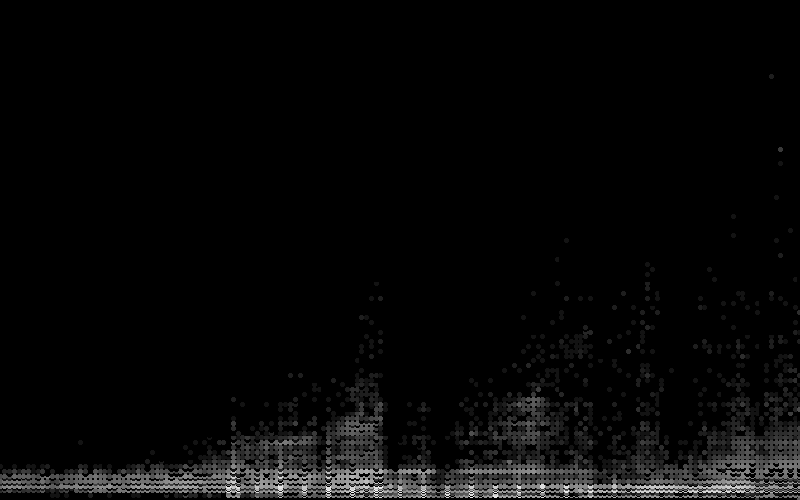

In [19]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

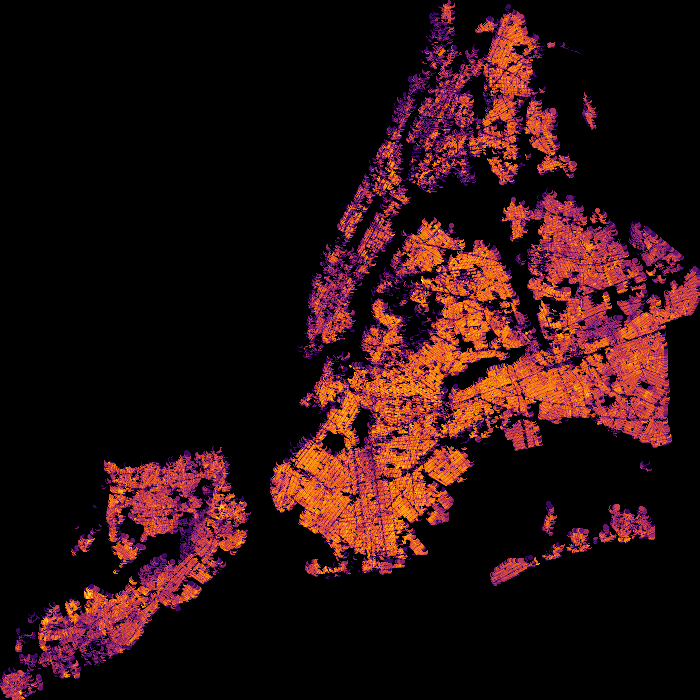

In [20]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### We will consider here the assesstot, assessland and the coordinates (xcoord, ycoord) columns. For calculation, we will subtract the total assesment from the land assessment to get the building assessment.

### I will describe below 2 ways of assessment without and with using choropleth maps.

### Without using choropleth map

In [21]:
import warnings
warnings.filterwarnings('ignore')

assess_data = ny[['assesstot', 'assessland','xcoord','ycoord']].copy()

assess_data['assessstructure'] = assess_data['assesstot'] - assess_data['assessland']
assess_data['assess-difference'] = assess_data['assessland'] - assess_data['assessstructure'] 

def assessment(data):
    if data['assess-difference'] == 0:
        return 'nodifference'
    elif data['assess-difference'] > 0:
        return 'underbuilt'
    else:
        return 'overbuilt'

# add the marker into our existing data 
assess_data['assessment'] = assess_data.apply(assessment, axis = 1)
assess_data['assessment'] = pd.Categorical(assess_data['assessment'])
assess_data.head(10)

assesstot  assessland     xcoord    ycoord  assessstructure  \
17      5918.0      5918.0  1008419.0  165883.0              0.0   
58     66780.0     51000.0   995995.0  204223.0          15780.0   
79    381150.0    158850.0  1004619.0  194842.0         222300.0   
110   977850.0     10350.0   998601.0  211689.0         967500.0   
126   255600.0     55350.0   994376.0  166232.0         200250.0   
130    68220.0     12600.0  1005279.0  192182.0          55620.0   
141    27720.0      8400.0  1008177.0  173575.0          19320.0   
146    43140.0     15960.0  1040194.0  192394.0          27180.0   
161   174361.0     21002.0  1013707.0  175198.0         153359.0   
165   374850.0      7200.0  1006705.0  214190.0         367650.0   

     assess-difference  assessment  
17              5918.0  underbuilt  
58             35220.0  underbuilt  
79            -63450.0   overbuilt  
110          -957150.0   overbuilt  
126          -144900.0   overbuilt  
130           -43020.0   overbuilt  
141           -10920.0   overbuilt  
146           -11220.0   overbuilt  
161          -132357.0   overbuilt  
165          -360450.0   overbuilt

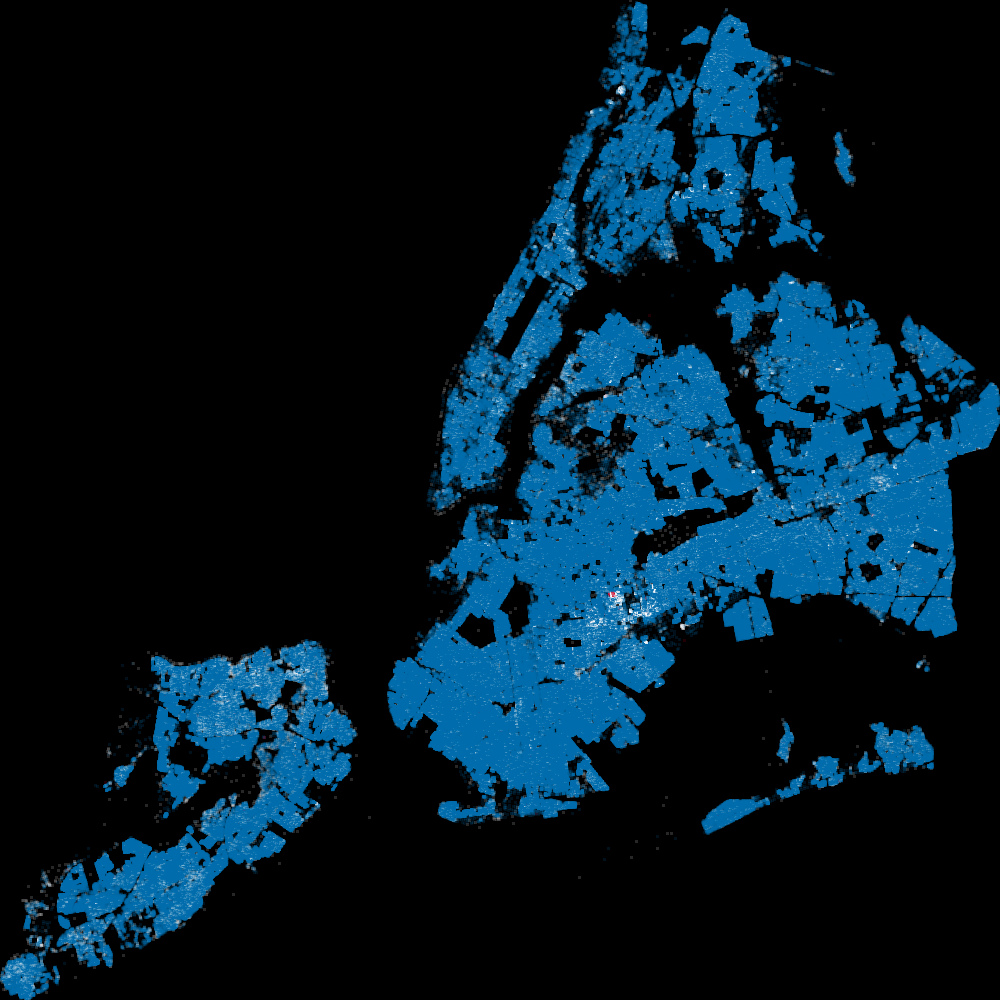

In [22]:
# #cc0024 - Red :- nodifference
# #fcfbfd - White :- underbuilt
# #016eae - Blue :- overbuilt

colors = {'nodifference': '#cc0024', 'underbuilt': '#fcfbfd', 'overbuilt': '#016eae'}

NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(1000, 1000, *NewYorkCity)

agg = cvs.points(assess_data, 'xcoord', 'ycoord',  ds.count_cat('assessment'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'bivariate')

### Using choropleth map

In [23]:
assess_data = ny[['assesstot', 'assessland','xcoord','ycoord']].copy()

assess_data['assessstructure'] = assess_data['assesstot'] - assess_data['assessland']

# Divide each variable into percentiles bin 
cat_labels = [['A', 'B', 'C'], ['1', '2', '3']]
q_perc = np.percentile(assess_data[['assessland', 'assessstructure']], [100/3, 100 - 100/3], axis=0)

assess_data['land_cat'] = pd.cut(assess_data['assessland'], 
                            [0, q_perc[0][0], q_perc[1][0], np.inf], 
                            right=False, 
                            labels=cat_labels[0]) 

assess_data['struct_cat'] = pd.cut(assess_data['assessstructure'], 
                              [0, q_perc[0][1], q_perc[1][1], np.inf], 
                              right=False, 
                              labels=cat_labels[1])

# Combine into new cat variable
assess_data['bi_cat'] = assess_data['land_cat'].astype(str) + assess_data['struct_cat'].astype(str)
assess_data['bi_cat'] = assess_data['bi_cat'].astype('category')
assess_data.head()

assesstot  assessland     xcoord    ycoord  assessstructure land_cat  \
17      5918.0      5918.0  1008419.0  165883.0              0.0        A   
58     66780.0     51000.0   995995.0  204223.0          15780.0        C   
79    381150.0    158850.0  1004619.0  194842.0         222300.0        C   
110   977850.0     10350.0   998601.0  211689.0         967500.0        A   
126   255600.0     55350.0   994376.0  166232.0         200250.0        C   

    struct_cat bi_cat  
17           1     A1  
58           1     C1  
79           3     C3  
110          3     A3  
126          3     C3

In [24]:

colors1 = {'A1': '#e8e8e8', 'A2': '#dfb0d6', 'A3': '#be64ac', 
          'B1': '#ace4e4', 'B2': '#a5add3', 'B3': '#8c62aa', 
          'C1': '#5ac8c8', 'C2': '#5698b9', 'C3': '#3b4994'}

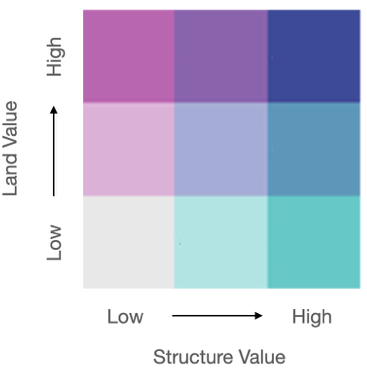

In [25]:
from IPython.display import Image
Image(filename='mod2.png') 

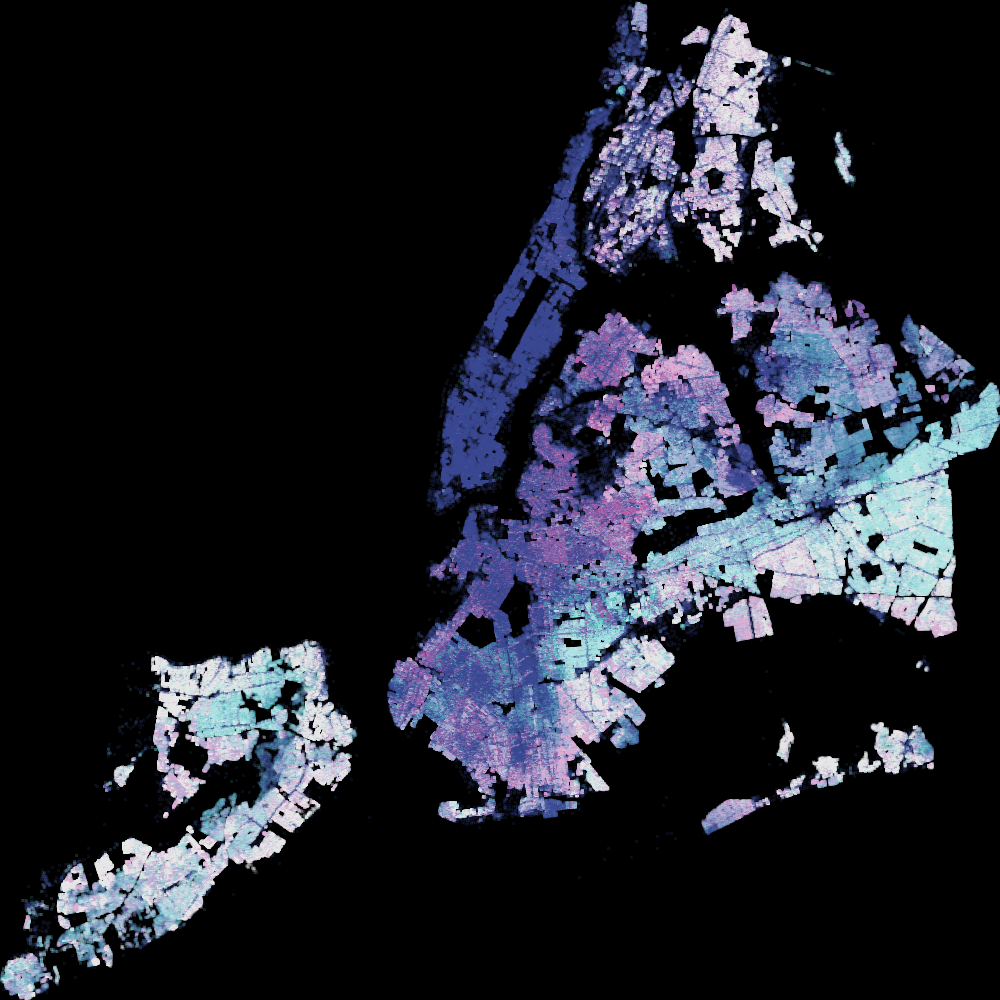

In [26]:

agg = cvs.points(assess_data, 'xcoord', 'ycoord',  ds.count_cat('bi_cat'))
view = tf.shade(agg, color_key = colors1)
export(tf.spread(view, px=1), 'bivariate')

### With the above two maps, we can derive useful information. It highlights Manhattan is mostly overbuilt area having valuable land and valuable structures. Brooklyn and Queens also have a significant amount of overbuilt areas but lesser as compared to Manhattan. On the other side, many areas of Staten Island and Bronx appear as underbuilt. This is really cool information for land assessment.